In [1]:
from IPython.display import display

from sympy import *
init_printing()

from monom import *

In [2]:
t, x, tau, h = symbols(r't, x, tau, h', real=True)
u = symbols('u', cls=Function)(t, x)

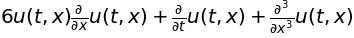

In [3]:
eq = u.diff(t) + 3*diff(u**2, x) + u.diff(x, 3)
eq

In [9]:
y1 = symbols('y', cls=Function)
y = y1(x)
dsolve(x*y.diff(x) + y - 3, y, ics={y1(1): 6})

In [7]:
integrate(integrate((1 - 2*x)/x**2, x), x)

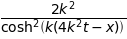

\frac{2 k^{2}}{\cosh^{2}{\left (k \left(4 k^{2} t - x\right) \right )}}


In [12]:
k = symbols('k', real=True)
exact1 = 2*k**2/cosh(-k*(4*k**2*t - x))**2
display(exact1)
display(eq.subs({u: exact1}).doit().trigsimp())
print(latex(exact1))

In [14]:
exact1 = 2*k**2*(1 - tanh(-k*(4*k**2*t - x))**2)
display(exact1)
eq.subs({u: exact1}).doit().trigsimp()

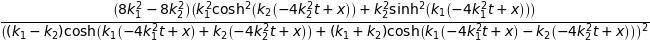

\frac{\left(8 k_{1}^{2} - 8 k_{2}^{2}\right) \left(k_{1}^{2} \cosh^{2}{\left (k_{2} \left(- 4 k_{2}^{2} t + x\right) \right )} + k_{2}^{2} \sinh^{2}{\left (k_{1} \left(- 4 k_{1}^{2} t + x\right) \right )}\right)}{\left(\left(k_{1} - k_{2}\right) \cosh{\left (k_{1} \left(- 4 k_{1}^{2} t + x\right) + k_{2} \left(- 4 k_{2}^{2} t + x\right) \right )} + \left(k_{1} + k_{2}\right) \cosh{\left (k_{1} \left(- 4 k_{1}^{2} t + x\right) - k_{2} \left(- 4 k_{2}^{2} t + x\right) \right )}\right)^{2}}


In [18]:
k1, k2 = symbols('k1, k2', real=True)
xi1, xi2 = k1*(x - 4*k1**2*t), k2*(x - 4*k2**2*t)
exact2 = 8*(k1**2 - k2**2)*(k1**2*cosh(xi2)**2 + k2**2*sinh(xi1)**2)/\
        ((k1 - k2)*cosh(xi1 + xi2) + (k1 + k2)*cosh(xi1 - xi2))**2
display(exact2)
print(latex(exact2))

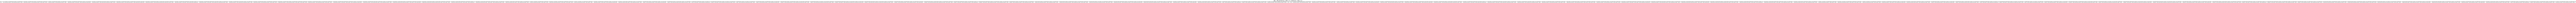

In [24]:
exact2a = expand_trig(exact2)
exact2a

In [25]:
exact2b = exact2a.rewrite(tanh)

In [26]:
eq.subs({u: exact2b}).doit().trigsimp()

KeyboardInterrupt: 

In [10]:
pda_f, pda_v = (u,), (t, x)
pda_n, pda_clp = (5, 5), (3, 3)
pda_p = Rational(1, 2), Rational(0, 1)

In [11]:
Monom.variables = 1 + len(pda_v)
Monom.zero = Monom(0 for v in range(Monom.variables))
pda_fun = dict(zip(pda_f,\
             (Monom(0 if v else i for v in range(Monom.variables))\
              for i in range(1, Monom.variables))))
pda_var = dict(zip(pda_v,\
             (Monom(0 if v != i else 1 for v in range(Monom.variables))\
              for i in range(1, Monom.variables))))

In [12]:
def T(f, i1, j1):
    return sum(sum(\
        diff(f, t, i, x, j)*(tau*(i1 - pda_p[0]))**i \
                             *(h*(j1 - pda_p[1]))**j/\
                 (factorial(i)*factorial(j))\
        for i in range(pda_n[0]))\
        for j in range(pda_n[1]))

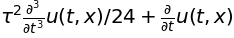

In [13]:
expand((T(u, 1, 0) - T(u, 0, 0))/(tau))

In [14]:
def clip(f):
    f = f.expand()
    r = []
    for i in range(pda_clp[0]):
        for j in range(pda_clp[1]):
            c = f.coeff(tau, i).coeff(h, j)
            if c and (\
            (pda_clp[0]-1 != i or j == 0) and \
            (pda_clp[1]-1 != j or i == 0)):
#             if c:
                r.append(((i, j), c))
    return r

def df2m(a):
    assert a.func == Derivative
    m = pda_fun[a.args[0]]
    for xi in a.args[1:]:
        if isinstance(xi, Symbol):
            m = m*pda_var[xi]
        else:
            m = m*pda_var[xi[0]]**xi[1]
    return m

def m2df(m):
    r = pda_f[m[0]-1]
    for i in range(1, len(m)):
        r = r.diff(pda_v[i-1], m[i])
    return r

def findDiv(a, d):
    r = None
    def find(a, r):
        if a.args:
            if a.func == Derivative and a.args[0] in pda_fun:
                m = df2m(a)
                if m.divisible(d) and (not r or m.cmp(r) > 0):
                    r = m
            else:
                for s in a.args:
                    r = find(s, r)
        return r
    return find(a, r)

def mult(a, s):
    r = []
    for mc in a:
        m = mc[0][0] + s[0], mc[0][1] + s[1]
        if m[0] < pda_clp[0] and m[1] < pda_clp[1] and\
           (pda_clp[0]-1 != m[0] or m[1] == 0) and \
           (pda_clp[1]-1 != m[1] or m[0] == 0):
            r.append((m, mc[1]))
    return r

def add(a, b):
    r, ia, ib = [], 0, 0
    iaend, ibend = len(a), len(b)
    while ia < iaend and ib < ibend:
        ma, mb = a[ia][0], b[ib][0]
        if ma[0] > mb[0]:
            c = 1
        elif ma[0] < mb[0]:
            c = -1
        elif ma[1] > mb[1]:
            c = 1
        elif ma[1] < mb[1]:
            c = -1
        else:
            c = 0
        
        if c == -1:
            r.append(a[ia])
            ia += 1
        elif c == 1:
            r.append(b[ib])
            ib += 1
        else:
            d = expand(a[ia][1] + b[ib][1])
            if d:
                r.append((ma, d))
            ia += 1
            ib += 1
    while ia < iaend:
        r.append(a[ia])
        ia += 1
    while ib < ibend:
        r.append(b[ib])
        ib += 1
    return r

def reduction(f1, f2, m, c, shift):
#     print(m, c, shift)
    f = mult(f2, shift)
    if not m:
        f = [(s, c*p) for s, p in f]
    else:
        f = [(s, c*p.diff(*m)) for s, p in f]
    return add(f1, f)

def NF(f, df, G, head=False):
    assert len(df) == len(G)
    ms = [df2m(d) for d in df]
    i = 0 if head else 1
    while i < len(f):
        shift, p = f[i]
        while True:
            r = None
            for l in range(len(ms)):
                r = findDiv(p, ms[l])
                if r:
                    break
            if not r: 
                break
            m = m2df(r)
#             print("find -", m)
            deg = p.as_poly(m).degree()
            c = p.coeff(m, deg)
            if deg > 1:
                c = p.coeff(m, deg)*m**(deg - 1)
            m = r/ms[l]
            d = []
            for k in range(len(pda_v)):
                if m[k+1] > 0:
                    d.append(pda_v[k])
                    if m[k+1] > 1:
                        d.append(m[k+1])
#             print(">"*6, tuple(d), -c/G[l][0][1].coeff(df[l]), shift)
#             prn(f)
            f = reduction(f, G[l], tuple(d), -c/G[l][0][1].coeff(df[l]), shift)
            if i == len(f):
                break
            shift, p = f[i]
#             print("<"*6)
#             prn(f)
        i += 1
    return f

def compact(f):
    def cmpct(a):
        if not a.args:
            return a
        else:
            if a in pda_f:
                return Symbol("%s" % a.func, real=True)
            elif a.func == Derivative:
                m = []
                for xi in a.args[1:]:
                    if isinstance(xi, Symbol):
                        m.append(str(xi))
                    else:
                        m.append(str(xi[0])*xi[1])
                return Symbol("%s_{%s}" % (a.args[0].func, "".join(m)), real=True)
            else:
                return a.func(*tuple(cmpct(s) for s in a.args))
    return cmpct(f)

def prn(a, p=None):
    for m, c in a:
        s = ""
        if m[0]:
            if m[0] == 1:
                s += "tau"
            else:
                s += "tau^%d" % m[0]
        if m[1]:
            if m[0]:
                s += " "
            if m[1] == 1:
                s += "h"
            else:
                s += "h^%d" % m[1]
        if s:
            print("%s =>" % s)
        if p:
            display(compact(c).collect(p, factor))
        else:
            display(compact(c))

def prnlatex(a, p=None):
    first = True
    for m, c in a:
        s = ""
        if m[0]:
            if m[0] == 1:
                s += r"\tau"
            else:
                s += r"\tau^%d" % m[0]
        if m[1]:
            if m[0]:
                s += " "
            if m[1] == 1:
                s += "h"
            else:
                s += r"h^%d" % m[1]
        if s:
            if first:
                first = False
                print(r"%s\left(" % s)
            else:
                print(r" + %s\left(" % s)
        if p:
            print(latex(compact(c).collect(p, factor)))
        else:
            print(latex(compact(c)))
        if first:
            first = False
        else:
            print(r"\right)") 

В результате получим следующую разностную схему для уравнения~(1.18), 
аналогичную схеме Кранка--Николсона для уравнения теплопроводности
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 +3\frac{\left({u^2}_{j+1}^{n+1} - {u^2}_{j-1}^{n+1}\right) +
              \left({u^2}_{j+1}^{n} - {u^2}_{j-1}^{n}\right)}{4h} + \\
 +\frac{\left({u}_{j+2}^{n+1} -2{u}_{j+1}^{n+1} +2{u}_{j-1}^{n+1} -{u}_{j-2}^{n+1}\right) +
             \left({u}_{j+2}^{n} -2{u}_{j}^{n+1} +2{u}_{j-1}^{n} -{u}_{j-2}^{n}\right)}{4h^{3}}=0.
\end{multline*}

In [15]:
def Dt(a):
    return (T(a, 1, 0) - T(a, 0, 0))/(tau)
def Dx(a):
    return ((T(a, 1, 1) - T(a, 1, -1))/(2*h) +\
            (T(a, 0, 1) - T(a, 0, -1))/(2*h))/2
def Dxxx(a):
    return ((T(a, 1, 2) - 2*T(a, 1, 1) + 2*T(a, 1, -1) - T(a, 1, -2))/(2*h**3) +\
            (T(a, 0, 2) - 2*T(a, 0, 1) + 2*T(a, 0, -1) - T(a, 0, -2))/(2*h**3))/2

In [16]:
Monom.cmp = Monom.TOPdeglex
pda_n, pda_clp = (6, 6), (3, 3)
pda_p = Rational(1, 2), Rational(0, 1)

In [17]:
F = clip(Dt(u) + 3*Dx(u**2) + Dxxx(u))
prn(F)
prnlatex(F)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\left(
u u_{xxx} + \frac{u_{xxxxx}}{4} + 3 u_{xx} u_{x}
\right)
 + \tau^2\left(
\frac{3 u u_{ttx}}{4} + \frac{u_{ttt}}{24} + \frac{u_{ttxxx}}{8} + \frac{3 u_{tt} u_{x}}{4} + \frac{3 u_{tx} u_{t}}{2}
\right)


In [18]:
Ffda = NF(F, [u.diff(x, 3)], [F], head=False)
prn(Ffda)
print(prnlatex(Ffda))

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\left(
3 u^{2} u_{x} + \frac{u u_{t}}{2} - \frac{u_{txx}}{4} - \frac{3 u_{xx} u_{x}}{2}
\right)
 + \tau^2\left(
- \frac{u_{ttt}}{12}
\right)
None


In [19]:
pda_p = Rational(0, 2), Rational(1, 1)

In [20]:
F = clip(Dt(u) + 3*Dx(u**2) + Dxxx(u))
prn(F)
prnlatex(F)

h =>


h^2 =>


tau =>


tau h =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h\left(
- 6 u u_{xx} - u_{tx} - u_{xxxx} - 6 u_{x}^{2}
\right)
 + h^2\left(
4 u u_{xxx} + \frac{u_{txx}}{2} + \frac{3 u_{xxxxx}}{4} + 12 u_{xx} u_{x}
\right)
 + \tau\left(
3 u u_{tx} + \frac{u_{tt}}{2} + \frac{u_{txxx}}{2} + 3 u_{t} u_{x}
\right)
 + \tau h\left(
- 3 u u_{txx} - \frac{u_{ttx}}{2} - \frac{u_{txxxx}}{2} - 6 u_{tx} u_{x} - 3 u_{t} u_{xx}
\right)
 + \tau^2\left(
\frac{3 u u_{ttx}}{2} + \frac{u_{ttt}}{6} + \frac{u_{ttxxx}}{4} + \frac{3 u_{tt} u_{x}}{2} + 3 u_{tx} u_{t}
\right)


In [21]:
Ffda = NF(F, [u.diff(x, 3)], [F], head=False)
prn(Ffda)
print(prnlatex(Ffda))

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\left(
3 u^{2} u_{x} + \frac{u u_{t}}{2} - \frac{u_{txx}}{4} - \frac{3 u_{xx} u_{x}}{2}
\right)
 + \tau^2\left(
- \frac{u_{ttt}}{12}
\right)
None


In [22]:
print(compact(Ffda[1][1]))

3*u**2*u_{x} + u*u_{t}/2 - u_{txx}/4 - 3*u_{xx}*u_{x}/2


In [23]:
print(compact(Ffda[2][1]))

-u_{ttt}/12


In [24]:
Ffda[1][1].subs({u: exact1}).doit().trigsimp().combsimp()

In [25]:
Ffda[2][1].subs({u: exact1}).doit().trigsimp().combsimp()

In [26]:
print(latex(Ffda[1][1].subs({u: exact1}).doit().combsimp()))

- 8 k^{7} \left(\tanh{\left (4 k^{3} t - k x \right )} - 1\right) \left(\tanh{\left (4 k^{3} t - k x \right )} + 1\right) \left(15 \tanh^{4}{\left (4 k^{3} t - k x \right )} - 16 \tanh^{2}{\left (4 k^{3} t - k x \right )} + 3\right) \tanh{\left (4 k^{3} t - k x \right )}


In [27]:
print(latex(Ffda[2][1].subs({u: exact1}).doit().combsimp()))

- \frac{256 k^{11} \left(\tanh{\left (4 k^{3} t - k x \right )} - 1\right) \left(\tanh{\left (4 k^{3} t - k x \right )} + 1\right) \left(3 \tanh^{2}{\left (4 k^{3} t - k x \right )} - 2\right) \tanh{\left (4 k^{3} t - k x \right )}}{3}


In [28]:
Monom.cmp = Monom.TOPlex
pda_p = Rational(1, 2), Rational(0, 1)

In [29]:
F = clip(Dt(u) + 3*Dx(u**2) + Dxxx(u))
prn(F)
prnlatex(F)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\left(
u u_{xxx} + \frac{u_{xxxxx}}{4} + 3 u_{xx} u_{x}
\right)
 + \tau^2\left(
\frac{3 u u_{ttx}}{4} + \frac{u_{ttt}}{24} + \frac{u_{ttxxx}}{8} + \frac{3 u_{tt} u_{x}}{4} + \frac{3 u_{tx} u_{t}}{2}
\right)


In [30]:
Ffda = NF(F, [u.diff(t)], [F], head=False)
prn(Ffda)
print(prnlatex(Ffda))

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\left(
u u_{xxx} + \frac{u_{xxxxx}}{4} + 3 u_{xx} u_{x}
\right)
 + \tau^2\left(
18 u^{3} u_{xxx} + 9 u^{2} u_{xxxxx} + 162 u^{2} u_{xx} u_{x} + \frac{3 u u_{xxxxxxx}}{2} + 63 u u_{xxxx} u_{x} + 99 u u_{xxx} u_{xx} + 108 u u_{x}^{3} + \frac{u_{xxxxxxxxx}}{12} + 6 u_{xxxxxx} u_{x} + \frac{27 u_{xxxxx} u_{xx}}{2} + 21 u_{xxxx} u_{xxx} + 81 u_{xxx} u_{x}^{2} + 99 u_{xx}^{2} u_{x}
\right)
None


In [31]:
pda_p = Rational(2, 2), Rational(-1, 1)

In [32]:
F = clip(Dt(u) + 3*Dx(u**2) + Dxxx(u))
prn(F)
prnlatex(F)

h =>


h^2 =>


tau =>


tau h =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h\left(
6 u u_{xx} + u_{tx} + u_{xxxx} + 6 u_{x}^{2}
\right)
 + h^2\left(
4 u u_{xxx} + \frac{u_{txx}}{2} + \frac{3 u_{xxxxx}}{4} + 12 u_{xx} u_{x}
\right)
 + \tau\left(
- 3 u u_{tx} - \frac{u_{tt}}{2} - \frac{u_{txxx}}{2} - 3 u_{t} u_{x}
\right)
 + \tau h\left(
- 3 u u_{txx} - \frac{u_{ttx}}{2} - \frac{u_{txxxx}}{2} - 6 u_{tx} u_{x} - 3 u_{t} u_{xx}
\right)
 + \tau^2\left(
\frac{3 u u_{ttx}}{2} + \frac{u_{ttt}}{6} + \frac{u_{ttxxx}}{4} + \frac{3 u_{tt} u_{x}}{2} + 3 u_{tx} u_{t}
\right)


In [33]:
Ffda = NF(F, [u.diff(t)], [F], head=False)
prn(Ffda)
print(prnlatex(Ffda))

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\left(
u u_{xxx} + \frac{u_{xxxxx}}{4} + 3 u_{xx} u_{x}
\right)
 + \tau^2\left(
18 u^{3} u_{xxx} + 9 u^{2} u_{xxxxx} + 162 u^{2} u_{xx} u_{x} + \frac{3 u u_{xxxxxxx}}{2} + 63 u u_{xxxx} u_{x} + 99 u u_{xxx} u_{xx} + 108 u u_{x}^{3} + \frac{u_{xxxxxxxxx}}{12} + 6 u_{xxxxxx} u_{x} + \frac{27 u_{xxxxx} u_{xx}}{2} + 21 u_{xxxx} u_{xxx} + 81 u_{xxx} u_{x}^{2} + 99 u_{xx}^{2} u_{x}
\right)
None


In [34]:
Ffda[1][1].subs({u: exact1}).doit().trigsimp().combsimp()

In [35]:
Ffda[2][1].subs({u: exact1}).doit().trigsimp().combsimp()

Наша $O(\tau^2, h^4)$:
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 - \frac{3}{24h}\left(\left({u^2}_{j+2}^{n+1} - 8{u^2}_{j+1}^{n+1} + 8{u^2}_{j-1}^{n+1} - {u^2}_{j-2}^{n+1}\right) 
              + \left({u^2}_{j+2}^{n} - 8{u^2}_{j+1}^{n} + 8{u^2}_{j-1}^{n} - {u^2}_{j-2}^{n}\right)\right) + \\
 - \frac{1}{16h^{3}}\left(\left({u}_{j+3}^{n+1} - 8{u}_{j+2}^{n+1} + 13{u}_{j+1}^{n+1} 
                                  - 13{u}_{j-1}^{n+1} + 8{u}_{j-2}^{n+1} - {u}_{j-3}^{n+1}\right) + \right. \\ \left.
             \left({u}_{j+3}^{n} - 8{u}_{j+2}^{n} + 13{u}_{j+1}^{n} 
                                  - 13{u}_{j-1}^{n} + 8{u}_{j-2}^{n} - {u}_{j-3}^{n}\right)\right)=0
\end{multline*}

In [36]:
def Dt(a):
    return (T(a, 1, 0) - T(a, 0, 0))/(tau)
def Dx(a):
    return -((T(a, 1, 2) - 8*T(a, 1, 1) + 8*T(a, 1, -1) - T(a, 1, -2))/(12*h) +\
             (T(a, 0, 2) - 8*T(a, 0, 1) + 8*T(a, 0, -1) - T(a, 0, -2))/(12*h))/2
def Dxxx(a):
    return -((T(a, 1, 3) - 8*T(a, 1, 2) + 13*T(a, 1, 1) -\
             13*T(a, 1, -1) + 8*T(a, 1, -2) - T(a, 1, -3))/(8*h**3) +\
            (T(a, 0, 3) - 8*T(a, 0, 2) + 13*T(a, 0, 1) -\
             13*T(a, 0, -1) + 8*T(a, 0, -2) - T(a, 0, -3))/(8*h**3))/2

In [37]:
Monom.cmp = Monom.TOPdeglex
pda_n, pda_clp = (6, 8), (3, 5)
pda_p = Rational(1, 2), Rational(0, 1)

In [38]:
F = clip(Dt(u) + 3*Dx(u**2) + Dxxx(u))
prn(F)
prnlatex(F)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\left(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120} - u_{xxxx} u_{x} - 2 u_{xxx} u_{xx}
\right)
 + \tau^2\left(
\frac{3 u u_{ttx}}{4} + \frac{u_{ttt}}{24} + \frac{u_{ttxxx}}{8} + \frac{3 u_{tt} u_{x}}{4} + \frac{3 u_{tx} u_{t}}{2}
\right)


In [39]:
Ffda = NF(F, [u.diff(x, 3)], [F], head=False)
prn(Ffda)
print(prnlatex(Ffda))

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\left(
\frac{27 u^{3} u_{x}}{5} + \frac{9 u^{2} u_{t}}{10} - \frac{u u_{txx}}{2} - \frac{81 u u_{xx} u_{x}}{5} - \frac{7 u_{ttx}}{120} - \frac{29 u_{tx} u_{x}}{20} - \frac{37 u_{t} u_{xx}}{20} - \frac{9 u_{x}^{3}}{2}
\right)
 + \tau^2\left(
- \frac{u_{ttt}}{12}
\right)
None


In [40]:
pda_p = Rational(-1, 2), Rational(2, 1)

In [41]:
F = clip(Dt(u) + 3*Dx(u**2) + Dxxx(u))
prn(F)
prnlatex(F)

h =>


h^2 =>


h^3 =>


h^4 =>


tau =>


tau h =>


tau h^2 =>


tau h^3 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h\left(
- 12 u u_{xx} - 2 u_{tx} - 2 u_{xxxx} - 12 u_{x}^{2}
\right)
 + h^2\left(
12 u u_{xxx} + 2 u_{txx} + 2 u_{xxxxx} + 36 u_{xx} u_{x}
\right)
 + h^3\left(
- 8 u u_{xxxx} - \frac{4 u_{txxx}}{3} - \frac{4 u_{xxxxxx}}{3} - 32 u_{xxx} u_{x} - 24 u_{xx}^{2}
\right)
 + h^4\left(
\frac{19 u u_{xxxxx}}{5} + \frac{2 u_{txxxx}}{3} + \frac{73 u_{xxxxxxx}}{120} + 19 u_{xxxx} u_{x} + 38 u_{xxx} u_{xx}
\right)
 + \tau\left(
6 u u_{tx} + u_{tt} + u_{txxx} + 6 u_{t} u_{x}
\right)
 + \tau h\left(
- 12 u u_{txx} - 2 u_{ttx} - 2 u_{txxxx} - 24 u_{tx} u_{x} - 12 u_{t} u_{xx}
\right)
 + \tau h^2\left(
12 u u_{txxx} + 2 u_{ttxx} + 2 u_{txxxxx} + 36 u_{txx} u_{x} + 36 u_{tx} u_{xx} + 12 u_{t} u_{xxx}
\right)
 + \tau h^3\left(
- 8 u u_{txxxx} - \frac{4 u_{ttxxx}}{3} - \frac{4 u_{txxxxxx}}{3} - 32 u_{txxx} u_{x} - 48 u_{txx} u_{xx} - 32 u_{tx} u_{xxx} - 8 u_{t} u_{xxxx}
\right)
 + \tau^2\left(
\frac{15 u u_{ttx}}{4} + \frac{13 u_{ttt}}{24} + \frac{5 u_{ttxxx}}{8} + \frac{15 

In [42]:
Ffda = NF(F, [u.diff(x, 3)], [F], head=False)
prn(Ffda)
print(prnlatex(Ffda))

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\left(
\frac{27 u^{3} u_{x}}{5} + \frac{9 u^{2} u_{t}}{10} - \frac{u u_{txx}}{2} - \frac{81 u u_{xx} u_{x}}{5} - \frac{7 u_{ttx}}{120} - \frac{29 u_{tx} u_{x}}{20} - \frac{37 u_{t} u_{xx}}{20} - \frac{9 u_{x}^{3}}{2}
\right)
 + \tau^2\left(
- \frac{u_{ttt}}{12}
\right)
None


In [43]:
print(compact(Ffda[1][1]))

27*u**3*u_{x}/5 + 9*u**2*u_{t}/10 - u*u_{txx}/2 - 81*u*u_{xx}*u_{x}/5 - 7*u_{ttx}/120 - 29*u_{tx}*u_{x}/20 - 37*u_{t}*u_{xx}/20 - 9*u_{x}**3/2


In [44]:
print(compact(Ffda[2][1]))

-u_{ttt}/12


In [45]:
Ffda[1][1].subs({u: exact1}).doit().trigsimp().combsimp()

In [46]:
Ffda[2][1].subs({u: exact1}).doit().trigsimp().combsimp()

In [47]:
print(latex(Ffda[1][1].subs({u: exact1}).doit().combsimp()))

\frac{32 k^{9} \left(\tanh{\left (4 k^{3} t - k x \right )} - 1\right) \left(\tanh{\left (4 k^{3} t - k x \right )} + 1\right) \left(945 \tanh^{6}{\left (4 k^{3} t - k x \right )} - 1800 \tanh^{4}{\left (4 k^{3} t - k x \right )} + 1014 \tanh^{2}{\left (4 k^{3} t - k x \right )} - 152\right) \tanh{\left (4 k^{3} t - k x \right )}}{15}


In [48]:
print(latex(Ffda[2][1].subs({u: exact1}).doit().combsimp()))

- \frac{256 k^{11} \left(\tanh{\left (4 k^{3} t - k x \right )} - 1\right) \left(\tanh{\left (4 k^{3} t - k x \right )} + 1\right) \left(3 \tanh^{2}{\left (4 k^{3} t - k x \right )} - 2\right) \tanh{\left (4 k^{3} t - k x \right )}}{3}


In [49]:
Monom.cmp = Monom.TOPlex
pda_p = Rational(1, 2), Rational(0, 1)

In [50]:
F = clip(Dt(u) + 3*Dx(u**2) + Dxxx(u))
prn(F)
prnlatex(F)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\left(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120} - u_{xxxx} u_{x} - 2 u_{xxx} u_{xx}
\right)
 + \tau^2\left(
\frac{3 u u_{ttx}}{4} + \frac{u_{ttt}}{24} + \frac{u_{ttxxx}}{8} + \frac{3 u_{tt} u_{x}}{4} + \frac{3 u_{tx} u_{t}}{2}
\right)


In [51]:
Ffda = NF(F, [u.diff(t)], [F], head=False)
prn(Ffda)
print(prnlatex(Ffda))

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\left(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120} - u_{xxxx} u_{x} - 2 u_{xxx} u_{xx}
\right)
 + \tau^2\left(
18 u^{3} u_{xxx} + 9 u^{2} u_{xxxxx} + 162 u^{2} u_{xx} u_{x} + \frac{3 u u_{xxxxxxx}}{2} + 63 u u_{xxxx} u_{x} + 99 u u_{xxx} u_{xx} + 108 u u_{x}^{3} + \frac{u_{xxxxxxxxx}}{12} + 6 u_{xxxxxx} u_{x} + \frac{27 u_{xxxxx} u_{xx}}{2} + 21 u_{xxxx} u_{xxx} + 81 u_{xxx} u_{x}^{2} + 99 u_{xx}^{2} u_{x}
\right)
None


In [52]:
pda_n, pda_clp = (6, 8), (3, 5)
pda_p = Rational(3, 2), Rational(2, 1)

In [53]:
F = clip(Dt(u) + 3*Dx(u**2) + Dxxx(u))
prn(F)
prnlatex(F)

h =>


h^2 =>


h^3 =>


h^4 =>


tau =>


tau h =>


tau h^2 =>


tau h^3 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h\left(
- 12 u u_{xx} - 2 u_{tx} - 2 u_{xxxx} - 12 u_{x}^{2}
\right)
 + h^2\left(
12 u u_{xxx} + 2 u_{txx} + 2 u_{xxxxx} + 36 u_{xx} u_{x}
\right)
 + h^3\left(
- 8 u u_{xxxx} - \frac{4 u_{txxx}}{3} - \frac{4 u_{xxxxxx}}{3} - 32 u_{xxx} u_{x} - 24 u_{xx}^{2}
\right)
 + h^4\left(
\frac{19 u u_{xxxxx}}{5} + \frac{2 u_{txxxx}}{3} + \frac{73 u_{xxxxxxx}}{120} + 19 u_{xxxx} u_{x} + 38 u_{xxx} u_{xx}
\right)
 + \tau\left(
- 6 u u_{tx} - u_{tt} - u_{txxx} - 6 u_{t} u_{x}
\right)
 + \tau h\left(
12 u u_{txx} + 2 u_{ttx} + 2 u_{txxxx} + 24 u_{tx} u_{x} + 12 u_{t} u_{xx}
\right)
 + \tau h^2\left(
- 12 u u_{txxx} - 2 u_{ttxx} - 2 u_{txxxxx} - 36 u_{txx} u_{x} - 36 u_{tx} u_{xx} - 12 u_{t} u_{xxx}
\right)
 + \tau h^3\left(
8 u u_{txxxx} + \frac{4 u_{ttxxx}}{3} + \frac{4 u_{txxxxxx}}{3} + 32 u_{txxx} u_{x} + 48 u_{txx} u_{xx} + 32 u_{tx} u_{xxx} + 8 u_{t} u_{xxxx}
\right)
 + \tau^2\left(
\frac{15 u u_{ttx}}{4} + \frac{13 u_{ttt}}{24} + \frac{5 u_{ttxxx}}{8} + \frac{15 

In [54]:
Ffda = NF(F, [u.diff(t)], [F], head=False)
prn(Ffda)
print(prnlatex(Ffda))

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\left(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120} - u_{xxxx} u_{x} - 2 u_{xxx} u_{xx}
\right)
 + \tau^2\left(
18 u^{3} u_{xxx} + 9 u^{2} u_{xxxxx} + 162 u^{2} u_{xx} u_{x} + \frac{3 u u_{xxxxxxx}}{2} + 63 u u_{xxxx} u_{x} + 99 u u_{xxx} u_{xx} + 108 u u_{x}^{3} + \frac{u_{xxxxxxxxx}}{12} + 6 u_{xxxxxx} u_{x} + \frac{27 u_{xxxxx} u_{xx}}{2} + 21 u_{xxxx} u_{xxx} + 81 u_{xxx} u_{x}^{2} + 99 u_{xx}^{2} u_{x}
\right)
None


In [55]:
Ffda[1][1].subs({u: exact1}).doit().trigsimp().combsimp()

In [56]:
Ffda[2][1].subs({u: exact1}).doit().trigsimp().combsimp()